## Imports

In [1]:
# !pip install snntorch
# !pip install matplotlib
# !pip install nir
# !pip install torchviz
# !pip install graphviz
# !pip install torchview

In [2]:
import torch
import snntorch as snn
import snntorch.functional as SF
from snntorch import RSynaptic
from snntorch import spikeplot as splt
import matplotlib.pyplot as plt
import nir
import torch
import torch.nn as nn
from torchviz import make_dot
from IPython.display import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchview import draw_graph
import math

In [3]:
from model import SpikingNet
from train import Trainer
from options import Options
from graph import Graph
from mapping import Mapping
import utils

## Define model with modified RSynaptic

In [4]:
opt = Options()
# Initialize the network
net = SpikingNet(opt)

/home/aronbencsik/anaconda3/envs/test_env/lib/python3.8/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
torch.manual_seed(42)
sample_data = torch.randn(opt.num_steps, opt.num_inputs)

indices_to_lock = {
    "indices" : ((0, 1), (90, 50)),
    "layers"  : ("lif1","lif1")}

try:
    prediction, _ = net(sample_data, indices_to_lock["indices"])
except:
    prediction, _ = net(sample_data, indices_to_lock["indices"])

print("Updated weights:\n", net.lif1.recurrent.weight.data)

Updated weights:
 tensor([[ 0.0601,  0.0000,  0.0990,  ...,  0.0470, -0.0012,  0.0051],
        [-0.0613,  0.0924, -0.0545,  ...,  0.0257,  0.0190, -0.0355],
        [ 0.0440,  0.0226,  0.0243,  ...,  0.0807, -0.0782, -0.0438],
        ...,
        [ 0.0218, -0.0559,  0.0524,  ..., -0.0784,  0.0365,  0.0790],
        [-0.0097,  0.0266, -0.0418,  ...,  0.0556, -0.0394, -0.0081],
        [-0.0904, -0.0842,  0.0250,  ...,  0.0177, -0.0027, -0.0615]])


## NIR Graph

Extracted edges: [('lif1.lif', 'lif1.w_rec'), ('lif2', 'output'), ('lif1.w_rec', 'lif1.lif'), ('input', 'fc1'), ('fc2', 'lif2'), ('fc1', 'lif1.lif'), ('lif1.lif', 'fc2')]


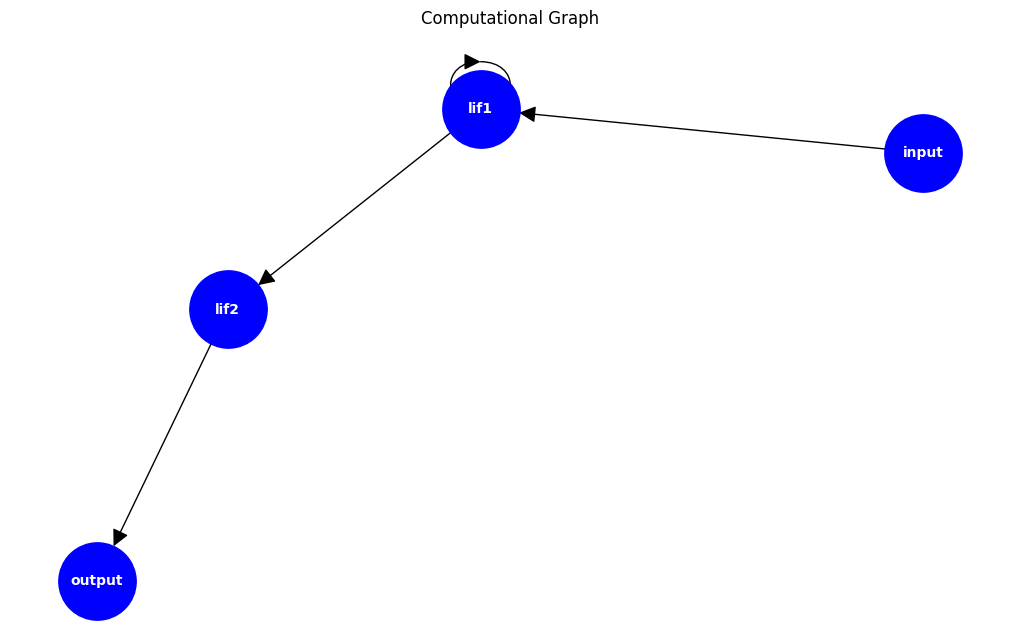

In [6]:
gp = Graph(opt.num_steps, opt.num_inputs)
gp.export_model(net)
gp.extract_edges()
gp.process_graph()
gp.plot_graph()

## Mapping

In [7]:
mapping = Mapping(net, opt.num_steps, opt.num_inputs, indices_to_lock)

total_neurons = sum(mapping.mem_potential_sizes.values())

core_capacity = max(math.ceil((total_neurons - opt.num_outputs) / (opt.num_cores - 1)), opt.num_outputs)

print(core_capacity)

mapping.set_core_capacity(core_capacity)

mapping.map_neurons()
#mem_potential_sizes = mapping.get_membrane_potential_sizes()
for layer_name, size in mapping.mem_potential_sizes.items():
    print(f"Layer: {layer_name}, Number of neurons: {size}")

for layer_name, allocations in mapping.core_allocation.items():
    print(f"Layer: {layer_name}")
    for core_id, start_idx, end_idx in allocations:
        print(f"  Core {core_id}: start index = {start_idx}, end index = {end_idx}")

print(mapping.core_allocation)
print(mapping.NIR_to_cores)
print(mapping.neuron_to_core)
print(mapping.buffer_map)

25
Layer: lif1, Number of neurons: 100
Layer: lif2, Number of neurons: 2
Layer: lif1
  Core 0: start index = 0, end index = 24
  Core 1: start index = 25, end index = 49
  Core 2: start index = 50, end index = 74
  Core 3: start index = 75, end index = 99
Layer: lif2
  Core 4: start index = 0, end index = 1
{'lif1': [(0, 0, 24), (1, 25, 49), (2, 50, 74), (3, 75, 99)], 'lif2': [(4, 0, 1)]}
{'lif1': [(0, 24), (1, 24), (2, 24), (3, 24)], 'lif2': [(4, 1)]}
{'lif1-0': 0, 'lif1-1': 0, 'lif1-2': 0, 'lif1-3': 0, 'lif1-4': 0, 'lif1-5': 0, 'lif1-6': 0, 'lif1-7': 0, 'lif1-8': 0, 'lif1-9': 0, 'lif1-10': 0, 'lif1-11': 0, 'lif1-12': 0, 'lif1-13': 0, 'lif1-14': 0, 'lif1-15': 0, 'lif1-16': 0, 'lif1-17': 0, 'lif1-18': 0, 'lif1-19': 0, 'lif1-20': 0, 'lif1-21': 0, 'lif1-22': 0, 'lif1-23': 0, 'lif1-24': 0, 'lif1-25': 1, 'lif1-26': 1, 'lif1-27': 1, 'lif1-28': 1, 'lif1-29': 1, 'lif1-30': 1, 'lif1-31': 1, 'lif1-32': 1, 'lif1-33': 1, 'lif1-34': 1, 'lif1-35': 1, 'lif1-36': 1, 'lif1-37': 1, 'lif1-38': 1, 'lif1-

## Train model

In [8]:
trainer = Trainer(net, num_epochs=10, learning_rate=1e-4, target_frequency=0.5, batch_size=16, num_steps=100)
net = trainer.train(opt.device)


----- TRAINING -----

Epoch [10/10], Loss: 39.4625


## Record Spikes

In [9]:
# Dictionary to store spikes from each layer

spike_record = {}
hooks = []

def reset_spike_record_and_hooks():
  global spike_record, hooks

  # Clear the spike_record dictionary
  spike_record = {}

  # Remove existing hooks if they are already registered
  if 'hooks' in globals():
    for hook in hooks:
      hook.remove()
      hooks = []

# Function to create a hook that records spikes
def create_spike_hook(layer_name):
  def hook(module, input, output):
    if layer_name not in spike_record:
      spike_record[layer_name] = []
    spike_record[layer_name].append(output[0].detach().cpu())
  return hook

reset_spike_record_and_hooks()

# Attach hooks automatically to all Leaky layers
for name, module in net.named_modules():
  if isinstance(module, snn.Leaky) or isinstance(module, snn.RSynaptic):
    hooks.append(module.register_forward_hook(create_spike_hook(name)))

#net, hooks = utils.attach_hooks(net)

### Record spike trains

In [10]:
import snntorch.spikeplot as splt
import matplotlib.pyplot as plt

# Dictionary to store spikes from each layer

# spike_record = {}
# hooks = []

# Generate random input data
indices = [1]
inputs = trainer.xor_inputs[indices]

# Generate spike trains
inputs = trainer.generate_spike_train(inputs, opt.num_steps).to(opt.device)

output, _ = net(inputs)

# Convert spike records to tensors for easier analysis
for layer_name in spike_record:
  spike_record[layer_name] = torch.squeeze(torch.stack(spike_record[layer_name]))

In [11]:
if 'hooks' in globals():
  for hook in hooks:
    hook.remove()
    hooks = []

## Construct Packets

### EXPERIMENTAL Dot product matrix

#### create map

In [12]:
import hashlib

# def bundle_target_cores(target_cores, min_reps):
#   res = []
#   new_target_cores = []
#   for target_core, reps in target_cores:
#     res.append(target_core)
#     if reps - min_reps > 0:
#       new_target_cores.append((target_core, reps - min_reps))

#   return res, new_target_cores

# def remove_unnecessary_packets(source_core, target_cores, buffer_map):
#   new_target_cores = []
#   for target_core, reps in target_cores:
#     if source_core == target_core:
#       continue
#     if str(source_core)+str(target_core) in buffer_map:
#       new_target_cores.append((target_core, reps - int(buffer_map[str(source_core)+str(target_core)])))
#     else:
#       new_target_cores.append((target_core, reps))

#   return new_target_cores

routing_matrices = {}
routing_map = {}

for layer_name, size in mapping.mem_potential_sizes.items(): # a way to get the layer names
  #routing_matrix = torch.zeros((opt.num_steps, size))
  routing_matrix = torch.zeros((size))
  for idx in range(size):

    if layer_name in routing_matrices:
      continue

    routing_id = layer_name +"-"+ str(idx)
    source_core = mapping.neuron_to_core[routing_id]

    downstream_nodes = list(gp.graph.successors(layer_name))

    target_cores = []
    for downstream_node in downstream_nodes:
      if downstream_node != "output":
        target_cores.extend(mapping.NIR_to_cores[downstream_node])

    # Remove skipped packets
    target_cores = utils.remove_unnecessary_packets(source_core, target_cores, mapping.buffer_map)

    # bundle packets (bundle several unicast packets into multicast)
    bundled_core_to_cores = []
    while len(target_cores) > 0:
      _, minimum = target_cores[0]
      for _, reps in target_cores:
        if reps < minimum:
          minimum = reps

      bcc, target_cores = utils.bundle_target_cores(target_cores, minimum)
      bundled_core_to_cores.append((bcc, minimum))

    packet_information = []
    for bcc, reps in bundled_core_to_cores:
      packet_information.append((source_core, bcc, reps))
      h = int(hashlib.shake_256(routing_id.encode()).hexdigest(2), 16)
      routing_map[h] = packet_information
      # for t in range(opt.num_steps):
      #   routing_matrix[t][idx] = h

      routing_matrix[idx] = h

  routing_matrices[layer_name] = routing_matrix

print(routing_matrices['lif1'])
print(routing_map)


tensor([ 2557., 19217., 52838., 35258., 36695.,  2865., 59987.,  3922., 22167.,
        20504., 14893., 30107., 48084., 44262., 50308., 41981., 22216., 41607.,
         1920., 18958., 60945., 18700., 24320., 10255., 24258., 59673., 54985.,
         3006., 58354., 15002., 56447., 40692., 10443., 23726., 26207., 53372.,
        62655., 10061., 56834., 63684.,  6150., 15835., 27290., 10736., 63309.,
        53733., 17110., 30160., 48842., 61152., 47534., 37514.,   531., 52679.,
        19584., 28624., 44013., 36861., 50195., 18030.,  1239.,  5415., 25635.,
        55110.,    76., 32664., 49111., 26031., 24390., 30122.,  8381., 43883.,
        12040., 51181., 41807., 28246., 55812., 41751.,  1464., 60225., 26074.,
        15318.,  8688., 61114.,  2530., 58597., 45133., 41165., 52123.,  7772.,
        12010., 15970.,  5863., 33676., 61217., 43078.,  9951., 62229., 38508.,
        47834.])
{2557: [(0, [4, 1, 2, 3], 1), (0, [1, 2, 3], 23)], 19217: [(0, [4, 1, 2, 3], 1), (0, [1, 2, 3], 23)], 5

#### perform dot product


In [14]:
# packets = []
# for layer_name, _ in mapping.mem_potential_sizes.items():
#   exp = torch.mul(routing_matrices[layer_name], spike_record[layer_name])

#   temp = exp[1]
#   non_zero_values = temp[temp != 0]

#   for hashes in non_zero_values:
#     packets.extend(routing_map[int(hashes)])

# print(packets)

print(spike_record["lif2"].shape)
print(routing_matrices["lif1"].shape)

packets = []

for t in range(opt.num_steps):
  #packets[t] = []
  for layer_name, _ in mapping.mem_potential_sizes.items():

    p = utils.dot_product(routing_matrices[layer_name], 
                                spike_record[layer_name][t], 
                                routing_map,
                                )
    
    packets.append(p)

print(packets)

torch.Size([100, 2])
torch.Size([100])
[[], [], [(0, [4, 1, 2, 3], 1), (0, [1, 2, 3], 23), (0, [4, 1, 2, 3], 1), (0, [1, 2, 3], 23), (0, [4, 1, 2, 3], 1), (0, [1, 2, 3], 23), (0, [4, 1, 2, 3], 1), (0, [1, 2, 3], 23), (0, [4, 1, 2, 3], 1), (0, [1, 2, 3], 23), (1, [4, 0, 2, 3], 1), (1, [0, 2, 3], 23), (1, [4, 0, 2, 3], 1), (1, [0, 2, 3], 23), (1, [4, 0, 2, 3], 1), (1, [0, 2, 3], 23), (1, [4, 0, 2, 3], 1), (1, [0, 2, 3], 23), (2, [4, 0, 1, 3], 1), (2, [0, 1, 3], 23)], [], [(0, [4, 1, 2, 3], 1), (0, [1, 2, 3], 23), (0, [4, 1, 2, 3], 1), (0, [1, 2, 3], 23), (0, [4, 1, 2, 3], 1), (0, [1, 2, 3], 23), (0, [4, 1, 2, 3], 1), (0, [1, 2, 3], 23), (0, [4, 1, 2, 3], 1), (0, [1, 2, 3], 23), (0, [4, 1, 2, 3], 1), (0, [1, 2, 3], 23), (0, [4, 1, 2, 3], 1), (0, [1, 2, 3], 23), (0, [4, 1, 2, 3], 1), (0, [1, 2, 3], 23), (0, [4, 1, 2, 3], 1), (0, [1, 2, 3], 23), (1, [4, 0, 2, 3], 1), (1, [0, 2, 3], 23), (1, [4, 0, 2, 3], 1), (1, [0, 2, 3], 23), (1, [4, 0, 2, 3], 1), (1, [0, 2, 3], 23), (1, [4, 0, 2, 3], 1),

In [15]:
# final_packet_list = []

# for source_core, destination_cores, reps in packets:
#     address = "00000"

#     # Convert string to list
#     string_list = list(address)

#     for index in destination_cores:
#         string_list[index] = '1'

#     # Convert list back to string
#     updated_address = ''.join(string_list)
#     for i in range(reps):
#         final_packet_list.append((source_core, updated_address))

# print(final_packet_list)
final_packets_list = []
for t in range(opt.num_steps):
    final_packets_list.append(utils.repeat_packets(packets[t]))

print(final_packets_list)

[[], [], [(0, '01111'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01111'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01111'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110'), (0, '01110